In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal

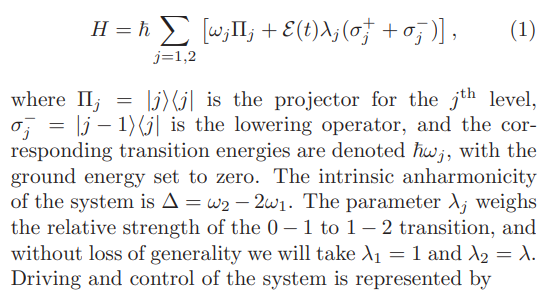

In [2]:
Omega_01 = 5.5  # Ghz
Delta = -0.25
Omega_02 = 2 * Omega_01 + Delta
Lambda = 0.8

ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()

In [3]:
# drift, control, R_frame
drift = 2 * np.pi * (Omega_01 * P1 + Omega_02 * P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda * (sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01 * P1 + 2 * Omega_01 * P2)

In [9]:
y0 = Statevector([1.0, 0.0, 0.0])
dt = 0.1
area = 0.42
sigma1 = 5  # ns
amp1 = area / sigma1
sigma2 = sigma1 / 3  # ns
amp2 = area / sigma2

duration = np.math.ceil(sigma1 * 5 / dt)
T = duration * dt  # ns

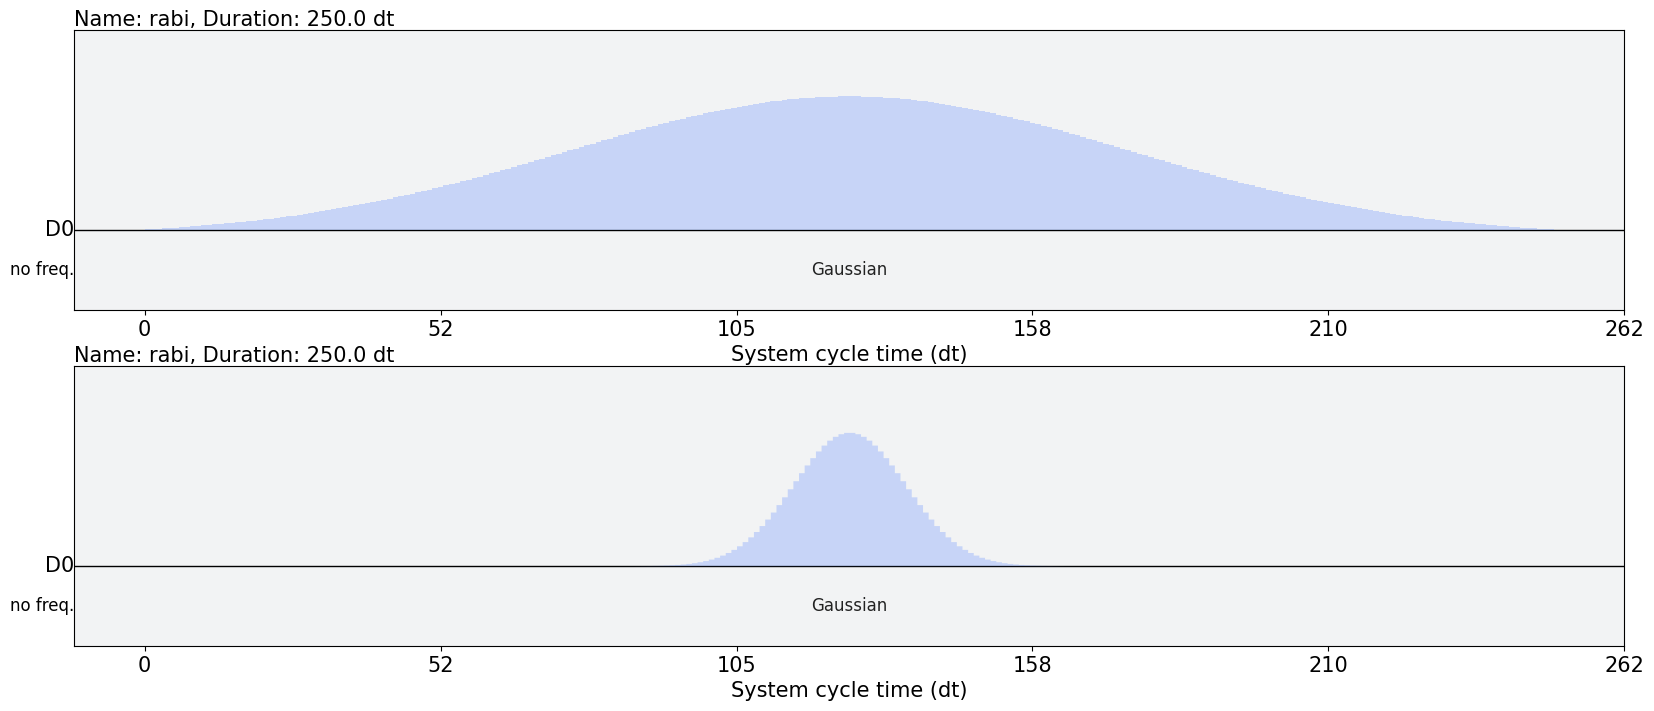

In [10]:
# signals = [Signal(envelope=1., carrier_freq=5.508)]
with pulse.build(name="rabi") as rb1:
    pulse.play(
        pulse.Gaussian(duration=duration, amp=amp1, sigma=sigma1 / dt),
        pulse.DriveChannel(0),
    )
with pulse.build(name="rabi") as rb2:
    pulse.play(
        pulse.Gaussian(duration=duration, amp=amp2, sigma=sigma2 / dt),
        pulse.DriveChannel(0),
    )

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
rb1.draw(axis=ax1)
rb2.draw(axis=ax2)

In [6]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
    rwa_cutoff_freq=1.5 * Omega_01,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": Omega_01},
    dt=dt,
)

In [7]:
solutions = hamiltonian_solver.solve(t_span=[0.0, T], y0=y0, signals=[rb1, rb2])

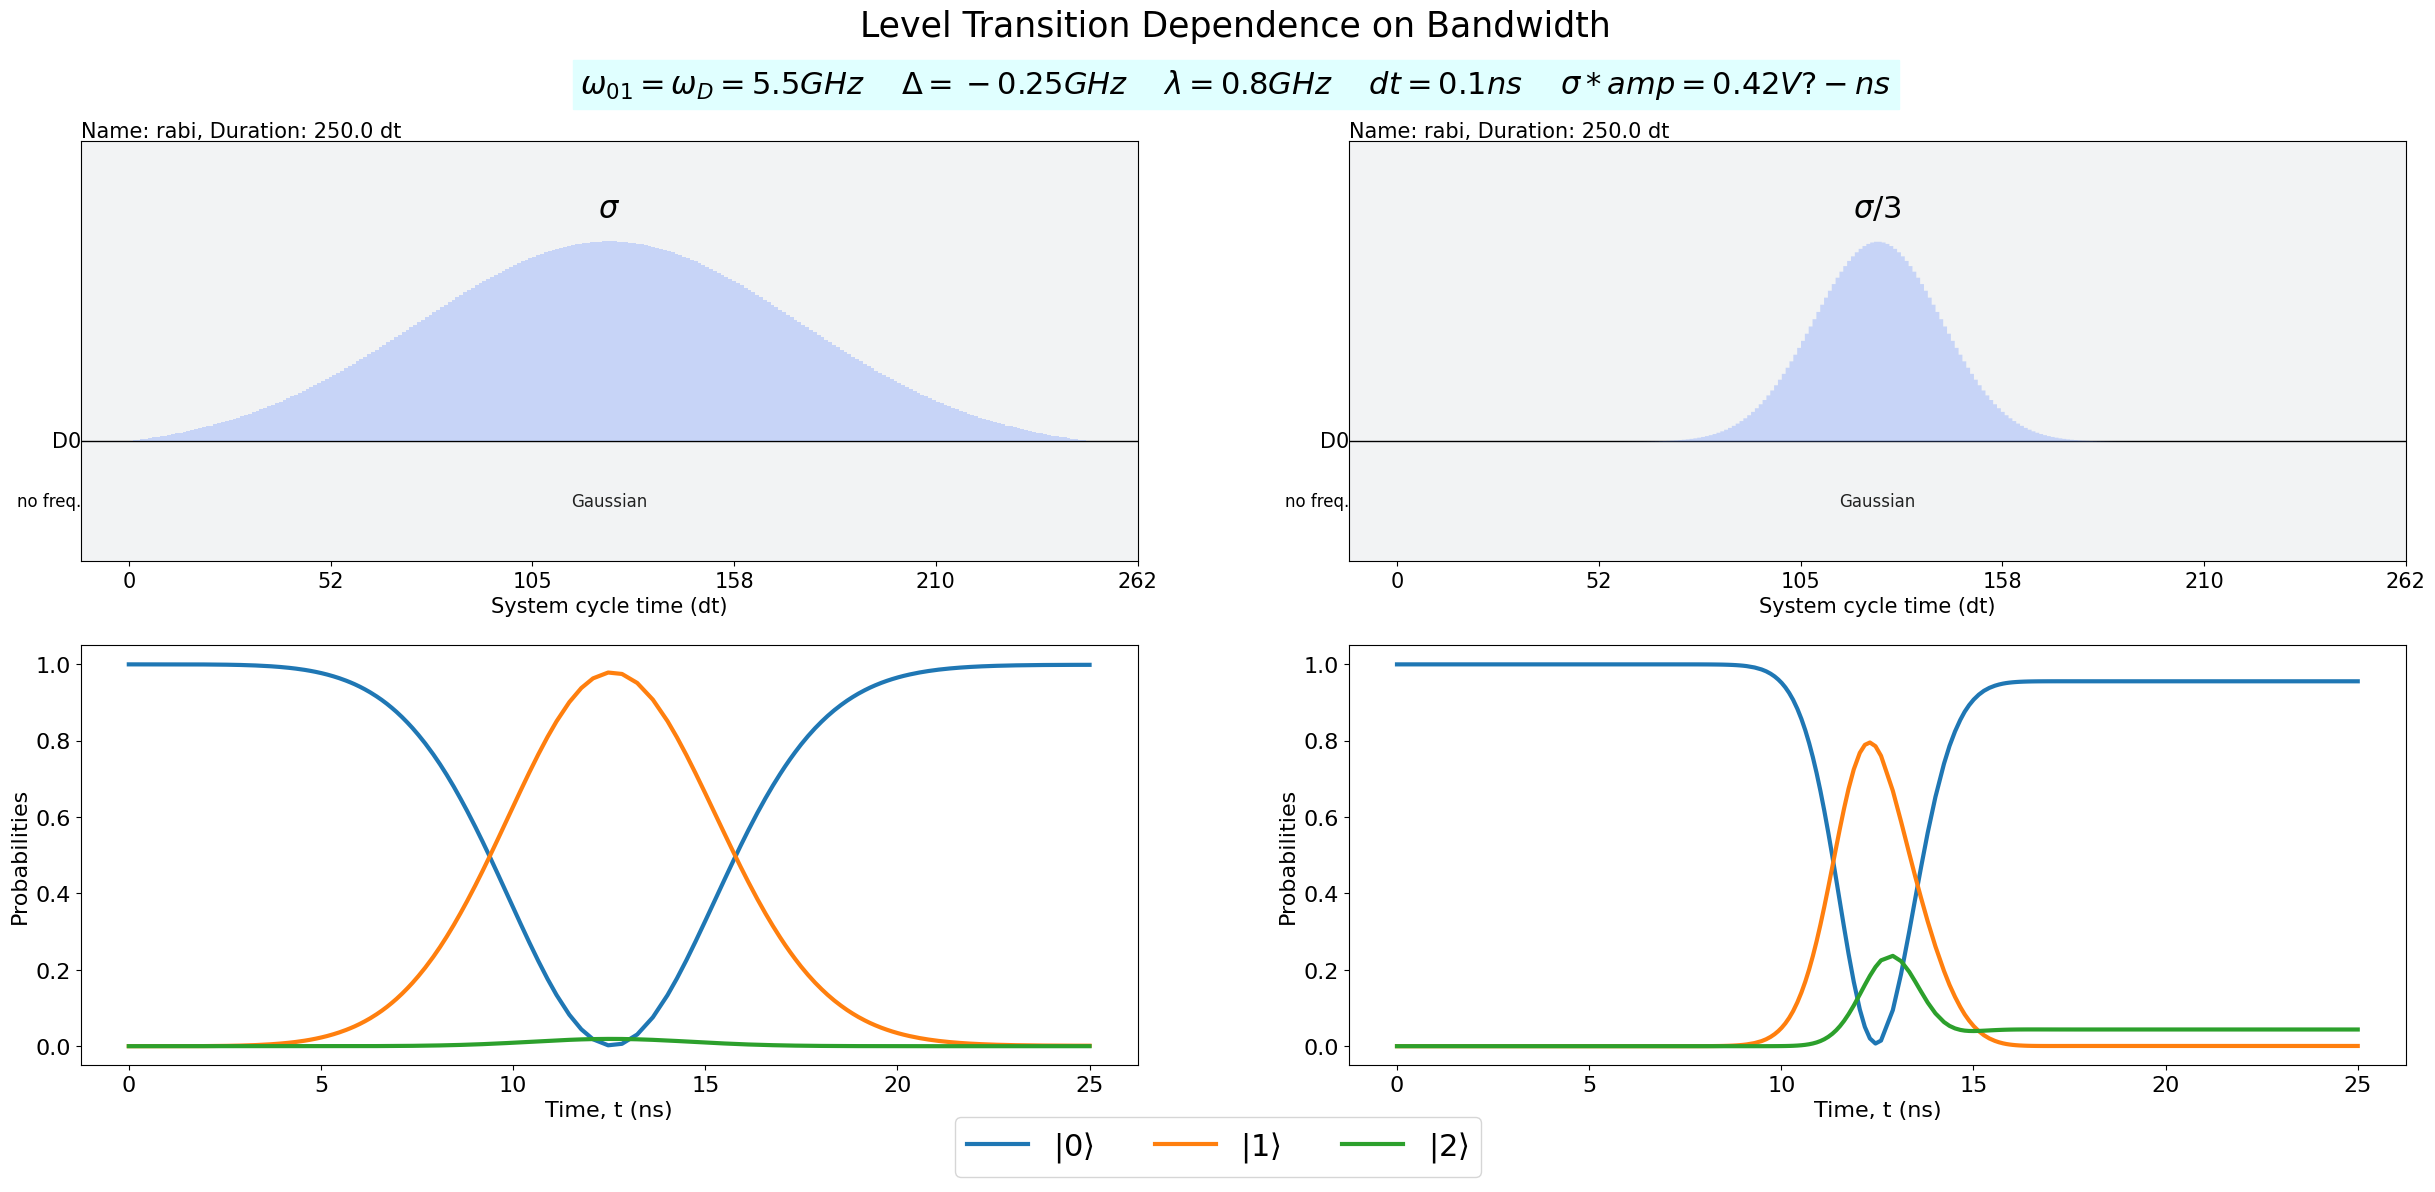

In [8]:
plt.close()
fig, (axis1, axis2) = plt.subplots(2, 2, figsize=(30, 12))

for ax, sol in zip(axis2, solutions):
    ax.plot(
        sol.t,
        np.array([psi.probabilities() for psi in sol.y])[:, 0],
        label=r"$|0\rangle$",
        linewidth=3,
    )
    ax.plot(
        sol.t,
        np.array([psi.probabilities() for psi in sol.y])[:, 1],
        label=r"$|1\rangle$",
        linewidth=3,
    )
    ax.plot(
        sol.t,
        np.array([psi.probabilities() for psi in sol.y])[:, 2],
        label=r"$|2\rangle$",
        linewidth=3,
    )
    ax.set_xlabel("Time, t (ns)", fontsize=16)
    ax.set_ylabel("Probabilities", fontsize=16)
axis1[0].set_title("$\sigma$", y=0.8, fontsize=22)
axis1[1].set_title("$\sigma / 3$", y=0.8, fontsize=22)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=22)

fig.suptitle("Level Transition Dependence on Bandwidth", x=0.51, y=0.99, fontsize=25)
fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}}=\omega_D = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$\sigma * amp = {area} V?-ns$"
    ),
    backgroundcolor="lightcyan",
    fontsize=22,
    horizontalalignment="center",
)

rb1.draw(axis=axis1[0])
rb2.draw(axis=axis1[1])
# fig.savefig("Rabi_std_comparison.pdf")